# Simulation of non-unitary components

We are interested in simulating a simple circuit with time delay and some loss channels.

In [1]:
import perceval as pcvl

## Perfect case

First, we define a HOM circuit with time delay. Since we are going to use non-unitary components, we will have to use a `Processor`. As we are going to compute all the probabilities, let's use a `SLOS` backend. In a first time, we will use a perfect source with no loss in the circuit.

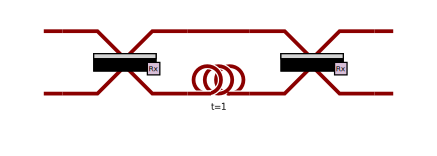

In [2]:
HOM = pcvl.Processor("SLOS", 2)

HOM.add(0, pcvl.BS())
HOM.add(1, pcvl.TD(1))
HOM.add(0, pcvl.BS())

pcvl.pdisplay(HOM)

Then, we define that we will send photons on mode 0. A photon will be sent to the circuit at each time step.

In [3]:
HOM.with_input(pcvl.BasicState([1, 0]))

Before going further, we will try to get an intuition of the result in this simple case.

Let's focus on a given time step $n$ with $n \ge 1$.
We will distinguish two cases: 
- either the photon of time step $n - 1$ went to mode 0 after the first beam splitter
- either it went to the mode 1 after the first beam splitter.
For both cases, the probability is 1/2 since we have a perfect beam splitter.
The photon of time $n$ can also go to mode 0 or mode 1 with probability 1/2 after the first beam splitter.

Let's start with the first case.
At time $n$, the photon of time $n - 1$ is no longer in the circuit. Thus it cannot interact with the photon of time $n$. <br>
If the latter went to mode 0, it will be detected at time $n$ on mode 0 or 1 with a 50/50 probability (since the second beam splitter is perfect too). <br>
If it went to mode 1, no photon will be detected at time $n$, giving us an empty state. <br>
This gives us the probability table for this case

\|0, 0$\rangle$ | \|1, 0$\rangle$ | \|0, 1$\rangle$ 
--- | --- | ---
1/2 | 1/4 | 1/4

Now let's consider the second case. <br>
If the photon at time $n$ went to mode 1, only the photon of time $n - 1$ will be detected. This will give us a |1, 0$\rangle$ or a |0, 1$\rangle$ state with 1/2 probability. <br>
If the photon at time $n$ went to mode 0, then the second beam splitter will have an input state |1, 1$\rangle$, which can only give us |2, 0$\rangle$ and |0, 2$\rangle$ states with 1/2 probability. <br>
This gives us the following probability table:

\|1, 0$\rangle$    |\|0, 1$\rangle$    |\|2, 0$\rangle$   |\|0, 2$\rangle$
--- | --- | --- | ---
1/4 | 1/4 | 1/4 | 1/4


Finally, we expect, considering each case has a probability of 1/2

|\|0, 0$\rangle$   |\|1, 0$\rangle$    |\|0, 1$\rangle$    |\|2, 0$\rangle$   |\|0, 2$\rangle$
--- | --- | --- | --- | ---
1/4 | 1/4 | 1/4 | 1/8 | 1/8

In [4]:
HOM.min_detected_photons_filter(0)

sampler = pcvl.algorithm.Sampler(HOM)
output = sampler.probs()["results"]

pcvl.pdisplay(output)

state,probability
"|1,0>",1/4
"|0,1>",1/4
"|0,0>",1/4
"|2,0>",1/8
"|0,2>",1/8


This is what we expected.

## Imperfect case

Now we are going to add some loss channel to our circuit to simulate an imperfect case. For a first use, we will check that loss channels on all modes are equivalent to source brightness with $loss = 1 - transmission$. We will not do it here, but we can also check that if loss channels are parallel in the circuit (so their result is not going in another loss channel), the computation also gives the same result.

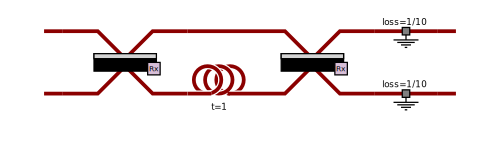

In [5]:
imperfect_HOM = pcvl.Processor("SLOS", 2, source=pcvl.Source(emission_probability=.6, multiphoton_component=.01))

imperfect_HOM.add(0, HOM)
imperfect_HOM.add(0, pcvl.LC(.1))
imperfect_HOM.add(1, pcvl.LC(.1))

pcvl.pdisplay(imperfect_HOM)

In [6]:
imperfect_HOM.with_input(pcvl.BasicState([1, 0]))
imperfect_HOM.min_detected_photons_filter(0)

imperfect_sampler = pcvl.algorithm.Sampler(imperfect_HOM)
output = imperfect_sampler.probs()["results"]

pcvl.pdisplay(output)

state,probability
"|0,0>",0.532244
"|1,0>",0.197039
"|0,1>",0.197039
"|2,0>",0.036546
"|0,2>",0.036546
"|1,1>",0.000387986
"|3,0>",4.9357e-05
"|2,1>",4.9357e-05
"|1,2>",4.9357e-05
"|0,3>",4.9357e-05


Now let's compute this using an imperfect source.

In [7]:
HOM.source = pcvl.Source(emission_probability=.6, multiphoton_component=.01, losses=.1)
# Here it is necessary to call with_input again to recompute the lossy input
HOM.with_input(pcvl.BasicState([1, 0]))

# No need to redefine the sampler even if the Processor has changed
output = sampler.probs()["results"]
pcvl.pdisplay(output)

state,probability
"|0,0>",0.532247
"|1,0>",0.197039
"|0,1>",0.197039
"|2,0>",0.036556
"|0,2>",0.036556
"|1,1>",0.000366166
"|3,0>",4.93856e-05
"|2,1>",4.93856e-05
"|1,2>",4.93856e-05
"|0,3>",4.93856e-05


We obtain the same distribution, which is what is expected.

## Playing with processors

Naturally, loss channels can have different loss values and be represented at several places of the circuit to represent each component loss, or detectors loss.

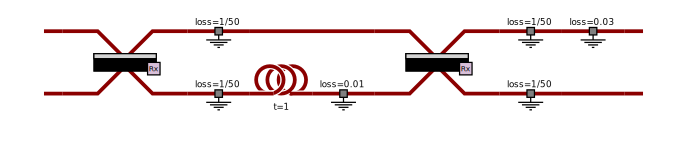

In [8]:
BS_loss = .02
TD_loss = .01

# Here, the backend name have no importance, as only the backend of the global processor will be used
lossy_BS = (pcvl.Processor("SLOS", 2)
            .add(0, pcvl.BS())
            .add(0, pcvl.LC(BS_loss))
            .add(1, pcvl.LC(BS_loss))
            )

lossy_TD = (pcvl.Processor("SLOS", 1)
            .add(0, pcvl.TD(1))
            .add(0, pcvl.LC(TD_loss))
            )

lossy_HOM = (pcvl.Processor("SLOS", 2)
             .add(0, lossy_BS)
             .add(1, lossy_TD)
             .add(0, lossy_BS)
             .add(0, pcvl.LC(.03))  # Lossy detector on mode 0
             )

pcvl.pdisplay(lossy_HOM)

In [9]:
lossy_HOM.with_input(pcvl.BasicState([1, 0]))
lossy_HOM.min_detected_photons_filter(0)

lossy_sampler = pcvl.algorithm.Sampler(lossy_HOM)
output = lossy_sampler.probs()["results"]

pcvl.pdisplay(output)

state,probability
"|0,0>",0.280276
"|0,1>",0.249513
"|1,0>",0.248671
"|0,2>",0.114143
"|2,0>",0.107397


We can see that the lossy detector gave us non-symmetrical results, with less probability to detect something on mode 0. An interesting fact is that the loss on the time delay does not alter the symmetry of the probabilities, because it is followed by a perfect beam splitter.

All functions of the processor remain available. For example, we can add some heralding. Let's take a simpler processor than in the previous case, to make results comparable.

First, here is a reminder of the probabilities of the imperfect HOM with a loss of 0.1 on each mode.

In [10]:
output = imperfect_sampler.probs()["results"]

pcvl.pdisplay(output)

state,probability
"|0,0>",0.532244
"|1,0>",0.197039
"|0,1>",0.197039
"|2,0>",0.036546
"|0,2>",0.036546
"|1,1>",0.000387986
"|3,0>",4.9357e-05
"|2,1>",4.9357e-05
"|1,2>",4.9357e-05
"|0,3>",4.9357e-05


Now we add a 0 herald on mode 1, and we will check that the results are correct.

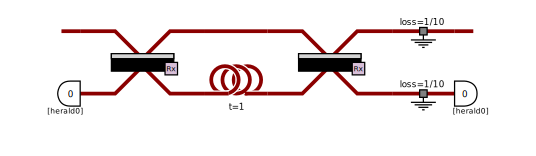

In [11]:
imperfect_HOM.add_herald(1, 0)
pcvl.pdisplay(imperfect_HOM)

In [12]:
expected = pcvl.BSDistribution()
expected_perf = 1
for state, prob in output.items():
    if state[1] == 0:
        expected[state[:1]] = prob
    else:
        expected_perf -= prob

print("expected performance", expected_perf)
# expected is not normalized here, but its display is
pcvl.pdisplay(expected)

expected performance 0.7658787302593201


state,probability
|0>,0.694946
|1>,0.257272
|2>,0.047718
|3>,6.44449e-05


In [13]:
output = imperfect_sampler.probs()

print("performance", output["logical_perf"])
pcvl.pdisplay(output["results"])

performance 0.7658787302593197


state,probability
|0>,0.694946
|1>,0.257272
|2>,0.047718
|3>,6.44449e-05


We obtain the same result in both cases.